In [2]:
"""
This file makes calls to functions in the michael_morris_github_code folder.
"""

import sys
sys.path.append("./../common/")
from utils import *
sys.path.append("./../michael_morris_github_code/")
from NNs import *
from DataConstructor import *

figures_dir = "../../dump/"
data_type = 'ili'
filename = 'ili'

10


In [2]:
# optimised hyperparameters
optimised = {'epochs': 474.76594498676836, 'kl_power': -2.6051346346427273, 'lr_power': -2.537369095970565, 'op_scale': 0.09887502370664345, 'prior_scale': 0.008947120568403435, 'q_scale': 0.09419376925608014, 'rnn_units': 43.141650695396926}

irnn_type = FIB_RNN
batch_size=32

if irnn_type.loss == "EDL":
    optimised["kl_power"] = None
    optimised["op_scale"] = None
    optimised["prior_scale"] = None
    optimised["q_scale"] = None
else:
    optimised['edl_coeff'] = None

gammas = [7,14,21,28]
test_seasons = [2015,2016,2017,2018]
models = {}

for gamma in gammas:
    _data = DataConstructor(gamma=gamma)
    x_train, y_train, x_test, y_test = _data(data_type, filename=filename)
    irnns = FI_NNs(rnn_units=optimised['rnn_units'], kl_power=optimised['kl_power'], op_scale=optimised['op_scale'], prior_scale=optimised['prior_scale'], q_scale=optimised['q_scale'], gamma=gamma, lr_power=optimised['lr_power'], n_batches=int(len(y_train)/batch_size), irnn_type=irnn_type, edl_coeff=optimised['edl_coeff'])
    history = irnns.train(x_train, y_train, epochs=int(optimised['epochs']), verbose=False)
    print(history)

    models[str(gamma)] = irnns

2023-03-18 23:56:45.231693: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[-2.7481002807617188, -4.11397647857666, -3.8653390407562256, -4.10495138168335, -2.7651453018188477, -3.9624838829040527, -4.102158069610596, -4.29573917388916, -3.0761351585388184, -3.909773349761963]
[-3.7037746906280518, -3.785771608352661, -2.6477510929107666, -3.7899837493896484, -3.8082330226898193, -0.5413831472396851, -3.7389280796051025, -3.5095126628875732, -3.154449939727783, -2.442535638809204]
[-3.1298439502716064, -3.7198991775512695, -3.244966983795166, -2.164077043533325, -2.6495375633239746, -2.8331329822540283, -3.095958948135376, -3.5105984210968018, -1.4181969165802002, -3.586998224258423]
[-2.7165074348449707, -3.3110148906707764, -1.728462815284729, -3.0083060264587402, -2.1116175651550293, -2.016331911087036, -2.392739772796631, -2.9960176944732666, -3.632131576538086, -2.009730815887451]


7
7 2015
LEN 10
7  diffs  [0.0049162377]
7  diffs  [0.00068741286]
7  diffs  [0.0006108218]
7  diffs  [0.00095931056]
7  diffs  [0.0009445711]
7  diffs  [0.0049129175]
7  diffs  [0.010813454]
7  diffs  [0.00088167447]
7  diffs  [0.00060764054]
7  diffs  [0.0006651166]
7 2016
LEN 10
7  diffs  [0.0007940246]
7  diffs  [0.00063157437]
7  diffs  [0.0006873781]
7  diffs  [0.0007119441]
7  diffs  [0.0045325495]
7  diffs  [0.0005765197]
7  diffs  [0.004592906]
7  diffs  [0.0006410526]
7  diffs  [0.0009819021]
7  diffs  [0.016382923]
7 2017
LEN 10
7  diffs  [0.000911661]
7  diffs  [0.0007386854]
7  diffs  [0.00084702927]
7  diffs  [0.0008753018]
7  diffs  [0.0046927375]
7  diffs  [0.00084389147]
7  diffs  [0.0007856562]
7  diffs  [0.012089584]
7  diffs  [0.006011229]
7  diffs  [0.0009739555]
7 2018
LEN 10
7  diffs  [0.00052609143]
7  diffs  [0.0006864119]
7  diffs  [0.00063509174]
7  diffs  [0.0042723943]
7  diffs  [0.0010149064]
7  diffs  [0.00054050295]
7  diffs  [0.00074945943]
7  diffs  [0

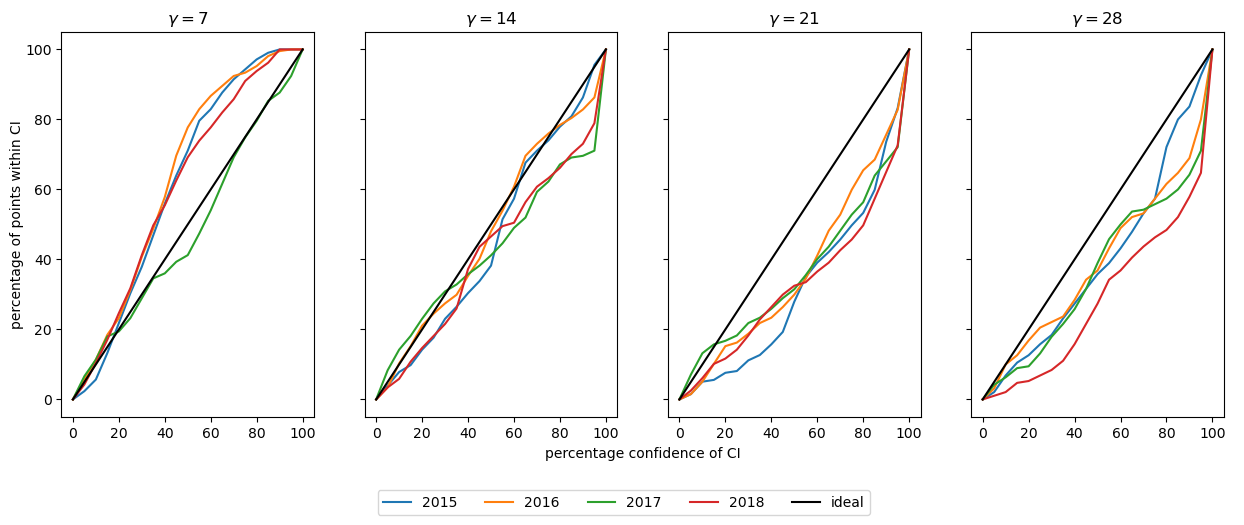

In [15]:
def gamma_data(array, gamma):
    if type(array) != type(np.array([])):
        array = array._numpy()
    return array.flatten()[:len(array)-gamma]

fig, axs = plt.subplots(1, len(models), figsize=(15, 5), sharey=True)
idx = 0

calibrations = {}
predictions = {}
Y_HAT, SD_HAT, MODEL_UNC, DATA_UNC = 0, 1, 2, 3
for gamma, model in models.items():
    calibrations[gamma] = {}
    predictions[gamma] = {}

confidences = get_confidence_axis()
for gamma, model in models.items():
    print(gamma)
    gamma_str = gamma
    gamma = int(gamma)

    for season in test_seasons:
        print(gamma, season)
        season_str = str(season)
        _data = DataConstructor(test_season=season, gamma=gamma)
        _, _, x_test, y_test = _data(data_type, filename=filename)
        predictions[gamma_str][season_str] = model.get_predictions(x_test, stable=True)
        in_range = unc_calibration(gamma_data(y_test[:,-1:,:], gamma), gamma_data(predictions[gamma_str][season_str][Y_HAT][:,-1:,:], gamma), gamma_data(predictions[gamma_str][season_str][SD_HAT][:,-1:,:], gamma))
        try:
            axs[idx].plot(confidences, in_range, label=str(season))
        except:
            print('in except')
            axs[idx].plot(confidences, in_range[1], label=str(season))
        calibrations[gamma_str][season_str] = in_range

    axs[idx].plot([0,100], [0,100], label="ideal", c="black")
    axs[idx].set_title('$\gamma = {}$'.format(gamma))
    idx += 1

save_multiplot_graph(fig, 'percentage confidence of CI', 'percentage of points within CI', figures_dir, 'test.png', test_seasons + ['ideal'])


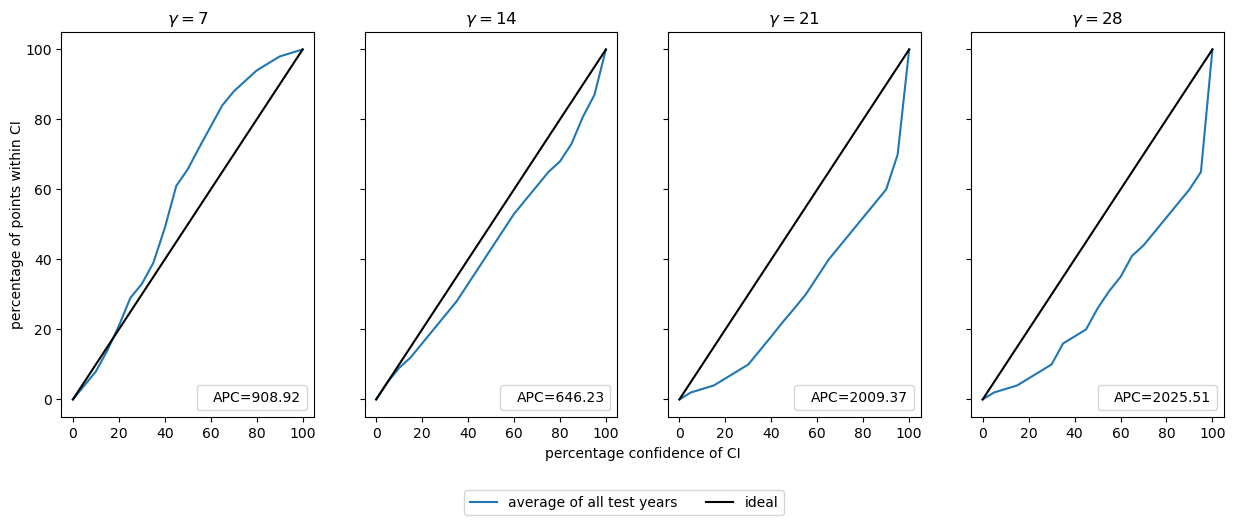

In [31]:
fig, axs = plt.subplots(1, len(models), figsize=(15, 5), sharey=True)
idx = 0
for gamma, calibration in calibrations.items():

    all_seasons = []
    for in_range in calibration.values():
        all_seasons.append(in_range)
    all_seasons = np.array(all_seasons)
    percentages = all_seasons.mean(axis=0).flatten()
    axs[idx].plot(confidences, percentages)

    axs[idx].plot([0,100], [0,100], label="APC={:.2f}".format(get_confidence_area(percentages)), c="black")
    axs[idx].set_title('$\gamma = {}$'.format(gamma))
    axs[idx].legend(handlelength=0, loc='lower right')
    idx += 1

save_multiplot_graph(fig, 'percentage confidence of CI', 'percentage of points within CI', figures_dir, 'test.png', labels=['average of all test years', 'ideal'])

In [14]:
# graphs on
test_year = 2015
test_gamma = 28
test_gamma_str = str(test_gamma)
test_year_str = str(test_year)

In [16]:
# UNNORMALISING
test_years = ['2015','2016','2017','2018']
for year in test_years:
    for gamma in gammas:
        _data = DataConstructor(gamma=gamma, test_season=int(year))
        _, _, _, y_test = _data(data_type, filename=filename)
        y_test = y_test._numpy()
        for i in range(gamma):
            y_hat = predictions[str(gamma)][year][Y_HAT][:,i,:].flatten()
            predictions[str(gamma)][year][Y_HAT][:,i,:] = rescale_array('y', y_hat, _data.scaler)
            predictions[str(gamma)][year][SD_HAT][:,i,:] = rescale_array('unc', predictions[str(gamma)][year][SD_HAT][:,i,:].flatten(), _data.scaler, y=y_hat)
            predictions[str(gamma)][year][DATA_UNC][:,i,:] = rescale_array('unc', predictions[str(gamma)][year][DATA_UNC][:,i,:].flatten(), _data.scaler, y=y_hat)
            predictions[str(gamma)][year][MODEL_UNC][:,i,:] = rescale_array('unc', predictions[str(gamma)][year][MODEL_UNC][:,i,:].flatten(), _data.scaler, y=y_hat)

(218, 7, 1)
(218, 14, 1)
(218, 21, 1)
(218, 28, 1)


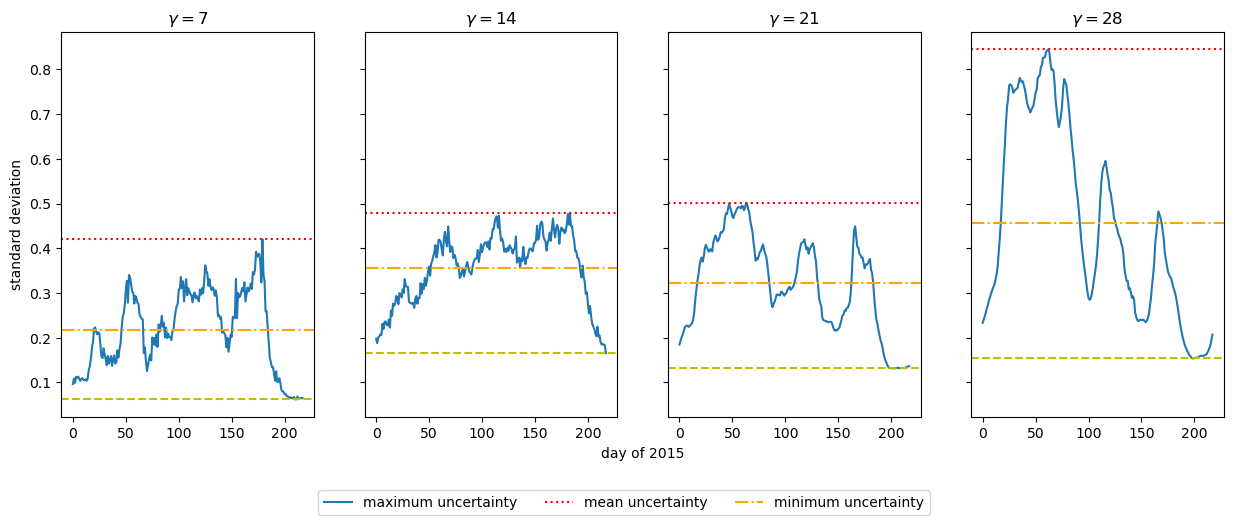

In [18]:
fig, axs = plt.subplots(1, len(models), figsize=(15, 5), sharey=True)
idx = 0
days = np.arange(0,365)
for gamma, prediction in predictions.items():

    print(prediction[test_year_str][SD_HAT].shape)

    sds = prediction[test_year_str][SD_HAT][:,-1:,:].flatten()
    axs[idx].plot(sds, label='$\gamma = {}$'.format(gamma))
    axs[idx].axhline(y = np.max(sds), color = 'r', linestyle = ':', label='maximum uncertainty')
    axs[idx].axhline(y = np.mean(sds), color = 'orange', linestyle = '-.', label='mean uncertainty')
    axs[idx].axhline(y = np.min(sds), color = 'y', linestyle = '--', label='minimum uncertainty')
    axs[idx].set_title('$\gamma = {}$'.format(gamma))
    idx += 1

save_multiplot_graph(fig, 'day of {}'.format(test_year_str), 'standard deviation', figures_dir, 'test.png', ['maximum uncertainty', 'mean uncertainty', 'minimum uncertainty'])

190 190 190 190


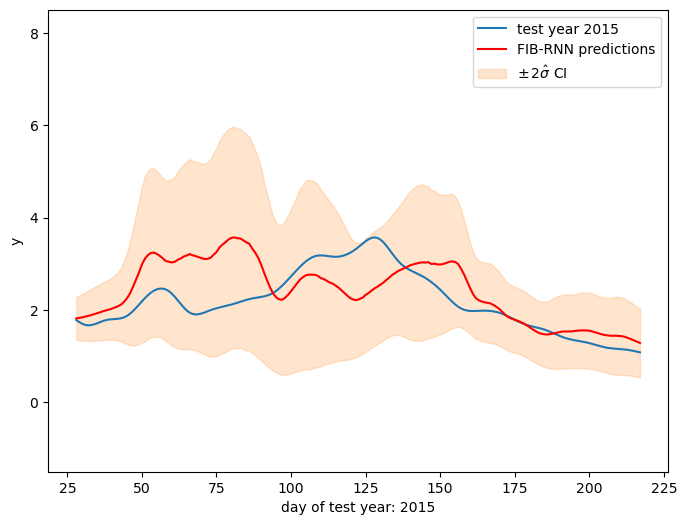

In [ ]:
# plot predictions and CIs
y_hat = predictions[test_gamma_str][test_year_str][Y_HAT][:,-1,:].flatten()[:len(y_test)-test_gamma]
sd_hat = predictions[test_gamma_str][test_year_str][SD_HAT][:,-1,:].flatten()[:len(y_test)-test_gamma]
_data = DataConstructor(gamma=test_gamma, test_season=test_year)
_, _, _, y_test = _data(data_type, filename=filename)
y_test = y_test._numpy()
y_test = rescale_array('y', y_test[:,test_gamma-1,:].flatten(), _data.scaler)
days = np.arange(test_gamma,len(y_test))
print(len(y_test)-test_gamma, len(days), len(y_hat), len(sd_hat))
while len(y_hat) != len(days) and len(sd_hat) != len(days):
    print(len(y_test)-test_gamma, len(days), len(y_hat), len(sd_hat))
    y_hat = predictions[test_gamma_str][test_year_str][Y_HAT][:,-1,:].flatten()[:len(y_test)-test_gamma]
    sd_hat = predictions[test_gamma_str][test_year_str][SD_HAT][:,-1,:].flatten()[:len(y_test)-test_gamma]

fig = plt.figure()
plt.plot(days, y_test.flatten()[:len(y_test)-test_gamma], label='test year {}'.format(test_year_str))
plt.plot(days, y_hat, c='r', label='FIB-RNN predictions')
ci_lower = y_hat - 2 * sd_hat
ci_upper = y_hat + 2 * sd_hat
plt.fill_between(np.squeeze(days), np.squeeze(ci_lower), np.squeeze(ci_upper), alpha=.2, label='$\pm\,2\hat\sigma$ CI', color='C1')
plt.ylim([-1.5,8.5])
save_xy_graph(fig, 'day of test year: {}'.format(test_year_str), 'y', figures_dir, 'test.png')

In [ ]:
from sklearn import metrics
import properscoring as ps
from scipy.stats import pearsonr

def nll_metric(true, pred, sd):
    return (-tfp.distributions.Normal(pred, sd).log_prob(true)).numpy().mean()

def skill_metric(true, pred, sd):
    dist = tfp.distributions.Normal(loc=pred, scale=sd)
    mbl = np.log((dist.cdf(true + 0.6) - dist.cdf(true - 0.5)).numpy())
    mbl[np.invert(np.isfinite(mbl))] = -10
    mbl[mbl<-10] = -10

    return np.exp(mbl.mean())

length_scoring = 365-test_gamma
nll_score = 0
mae_score = 0
mse_score = 0
crps_score = 0
skill_score = 0
r_score = 0
for year in test_years:
    _data = DataConstructor(gamma=test_gamma, test_season=int(year))
    _, _, _, y_test = _data(data_type, filename=filename)
    y_test = y_test._numpy()
    y_test = rescale_array('y', y_test[:,test_gamma-1,:].flatten(), _data.scaler)
    length_scoring = len(y_test)-test_gamma
    y_test = y_test.flatten()[:length_scoring]

    y_hat = predictions[test_gamma_str][year][Y_HAT][:,-1,:].flatten()[:length_scoring]
    sd_hat = predictions[test_gamma_str][year][SD_HAT][:,-1,:].flatten()[:length_scoring]

    nll_score += nll_metric(y_test, y_hat, sd_hat)
    mae_score += metrics.mean_absolute_error(y_test, y_hat)
    mse_score += metrics.mean_squared_error(y_test, y_hat)
    crps_score += ps.crps_gaussian(y_test, y_hat, sd_hat).mean()
    skill_score += skill_metric(y_test, y_hat, sd_hat)
    r_score += pearsonr(y_test, y_hat)[0]

nll_score /= len(test_years)
mae_score /= len(test_years)
mse_score /= len(test_years)
crps_score /= len(test_years)
skill_score /= len(test_years)
r_score /= len(test_years)

print('"NLL": ', nll_score, ',')
print('"MAE": ', mae_score, ',')
print('"MSE":', mse_score, ',')
print('"CRPS": ', crps_score, ',')
print('"Skill": ', skill_score, ',')
print('"r": ', r_score)


"NLL":  1.1261956691741943 ,
"MAE":  0.615702249109745 ,
"MSE": 0.8912926837801933 ,
"CRPS":  0.4534774646162987 ,
"Skill":  0.36076292395591736 ,
"r":  0.7469083799939396
